In this exercise we are going to use Boston Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.io import sql
import sqlite3

In [2]:
url = "https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/Boston.csv"
BostonData = pd.read_csv(url)
del BostonData['Unnamed: 0']
BostonData.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
X = BostonData.copy()
del X['medv']
y = BostonData['medv']

# Random Forest - Regression Problems

#### For documentation of RandomForestRegressor please refer to:
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [4]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators = 10000, #Number of trees - the more the better!
                           max_features = 4,     #How many features to randomly choose in each node 
                           min_samples_leaf = 5, #Minimum number of observations at each terminal node
                           oob_score = True)      #If you would like to record out of bage scores
                           # if you do not set maximum number of features, then you'll have bagging

RF.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10000, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [5]:
sorted(zip(RF.feature_importances_,X.columns.values))

[(0.0030523077306531528, 'chas'),
 (0.0061512268647293273, 'zn'),
 (0.0066105006648164346, 'rad'),
 (0.01347285758295412, 'black'),
 (0.022572255880147322, 'age'),
 (0.03058060656377953, 'tax'),
 (0.043822631647310338, 'dis'),
 (0.052939543741986485, 'crim'),
 (0.065229495692746622, 'nox'),
 (0.065240875376973054, 'indus'),
 (0.069160188754441645, 'ptratio'),
 (0.3076430179872881, 'lstat'),
 (0.31352449151217437, 'rm')]

In [6]:
RF.oob_score_  #this value is like R^2

0.84805321944948231

#### A time-consuming way to tune your model on m - # of Features

    Number of Features  cv_scores
0                    1   5.546255
1                    2   4.755471
2                    3   4.355726
3                    4   4.171966
4                    5   4.114264
5                    6   4.072683
6                    7   4.070253
7                    8   4.088561
8                    9   4.088456
9                   10   4.123688
10                  11   4.173775
11                  12   4.199293
12                  13   4.231131


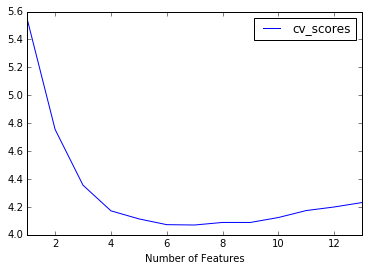

In [7]:
from sklearn.cross_validation import cross_val_score
features = range(1,14)
scores = []
for i in features:
    RF = RandomForestRegressor(n_estimators = 1000, #Number of trees - the more the better!
                           max_features = i,     #How many features to randomly choose in each node 
                           min_samples_leaf = 5, #Minimum number of observations at each terminal node
                           oob_score = True) 
    cv_error = cross_val_score(RF, X, y, cv=10, scoring='mean_squared_error')
    scores.append(np.mean(np.sqrt(-scores)))

num_features_df = pd.DataFrame({'cv_scores': scores,'Number of Features': features})
print num_features_df
num_features_df.plot(x ='Number of Features', y = 'cv_scores' )

# Remember in our previous lecture, we could only achieve error of 5.2. Here we reduced it to 4.1
# Seven features minimizes the mean square error

#### Let's check if choosing 1000 for number of trees was a good choice. (This may take a few minutes to run)

   Number of Trees  cv_scores
0             1000   4.076540
1             2000   4.049588
2             5000   4.058771
3            10000   4.058240


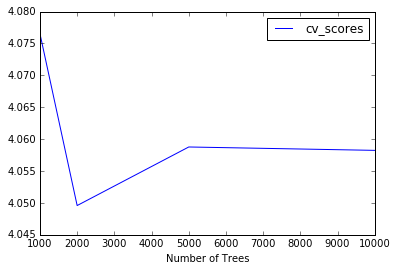

In [8]:
NumberOfTrees = [1000,2000,5000,10000]
scores = []
for i in NumberOfTrees:
    RF = RandomForestRegressor(n_estimators = i, #Number of trees - the more the better!
                           max_features = 7,     #How many features to randomly choose in each node 
                           min_samples_leaf = 5, #Minimum number of observations at each terminal node
                           oob_score = True) 
    cv_error = cross_val_score(RF, X, y, cv=10, scoring='mean_squared_error')
    scores.append(np.mean(np.sqrt(-cv_error)))

num_trees_df = pd.DataFrame({'cv_scores': scores, 'Number of Trees': NumberOfTrees })
print num_trees_df
num_trees_df.plot(x ='Number of Trees',y = 'cv_scores' )
# Look at the magnitude of CV_error. It sounds like we don't see that much improvement after 1000 trees

#### Using Out of Bag error to tune our models. This is so much faster than CV!

    Number of Features  Out of Bag Score
0                    1          0.731262
1                    2          0.809232
2                    3          0.836868
3                    4          0.847552
4                    5          0.851747
5                    6          0.849532
6                    7          0.851130
7                    8          0.849241
8                    9          0.845381
9                   10          0.842998
10                  11          0.840530
11                  12          0.838744
12                  13          0.841000


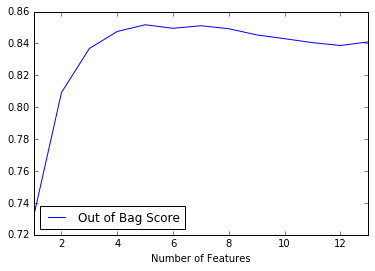

In [9]:
features = range(1,14)
oob_score_RF = []
for i in features:
    RF = RandomForestRegressor(n_estimators = 1000, #Number of trees - the more the better!
                           max_features = i,     #How many features to randomly choose in each node 
                           min_samples_leaf = 5, #Minimum number of observations at each terminal node
                           oob_score = True)
    RF.fit(X,y)  
    oob_score_RF.append(RF.oob_score_)

oob_score_df = pd.DataFrame({'Out of Bag Score': oob_score_RF, 'Number of Features': features})
print oob_score_df
oob_score_df.plot(x ='Number of Features', y = 'Out of Bag Score' )

# Out of bag score is R^2 - the larger the better. Again we can see our model works best when the number of features
# is around 5. Almost same story as CV - but in much faster time. 

# Random Forest - Categorical Variables

#### Let's first categorize medv to 4 groups. 
Lowest 20% medv is categorized as Level 1. Next 30% medv is categorized as Level 2. Next 30% medv is categorized as Level 3. Top 20% medv is categorized as Level 4

In [10]:
BostonData['medvCategory'] = '1'
mask_cat2 = ((BostonData['medv'] > BostonData['medv'].quantile(.2)) & 
            (BostonData['medv'] <= BostonData['medv'].quantile(.5)))   
mask_cat3 = ((BostonData['medv'] > BostonData['medv'].quantile(.5)) & 
            (BostonData['medv'] <= BostonData['medv'].quantile(.8)))  
mask_cat4 = (BostonData['medv'] > BostonData['medv'].quantile(.8)) 

BostonData.loc[mask_cat2,'medvCategory'] = '2'
BostonData.loc[mask_cat3,'medvCategory'] = '3'
BostonData.loc[mask_cat4,'medvCategory'] = '4'

In [11]:
y = BostonData['medvCategory']

Documentation for RandomForestClassifier http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [12]:
from sklearn.ensemble import RandomForestClassifier
RFClass = RandomForestClassifier(n_estimators = 1000, 
                                 max_features = 4, # You can set it to a number or 'sqrt', 'log2', etc
                                 min_samples_leaf = 5,
                                 oob_score = True)
RFClass.fit(X,y)
print(RFClass.oob_score_)
scores = cross_val_score(RFClass,X,y,cv=10)
print(scores.mean())
#out of bag error = 25% , CV_error is 35%

0.754940711462
0.650315002053


    Number of Features  Out of Bag Score
0                    1          0.727273
1                    2          0.741107
2                    3          0.762846
3                    4          0.750988
4                    5          0.762846
5                    6          0.750988
6                    7          0.733202
7                    8          0.752964
8                    9          0.737154
9                   10          0.735178
10                  11          0.741107
11                  12          0.737154
12                  13          0.733202


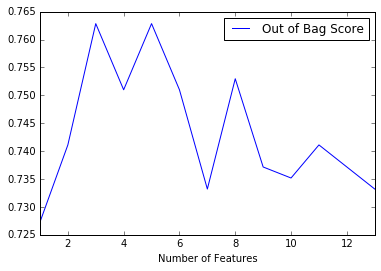

In [13]:
features = range(1,14)
oob_score_RF = []
for i in features:
        RFClass = RandomForestClassifier(n_estimators = 1000, #Number of trees - the more the better!
                           max_features = i,     #How many features to randomly choose in each node 
                           min_samples_leaf = 5, #Minimum number of observations at each terminal node
                           oob_score = True)
        RFClass.fit(X,y)  
        oob_score_RF.append(RFClass.oob_score_)

oob_score_df = pd.DataFrame({'Out of Bag Score': oob_score_RF ,'Number of Features': features})
print oob_score_df
oob_score_df.plot(x='Number of Features', y='Out of Bag Score' )

# It looks like choosing max_features as 2 is our best bet

In [17]:
RFClass = RandomForestClassifier(n_estimators = 1000, max_features = 5, min_samples_leaf = 5, oob_score = True)
RFClass.fit(X,y)
print(RFClass.oob_score_)
scores = cross_val_score(RFClass,X,y,cv=10)
print(scores.mean())
# y_hat = RFClass.predict(X)
# Minimal change to error rates

0.754940711462
0.650195754354


# Boosting Algorithm - Regression

For full documention, please refer to: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

In [18]:
# Change y back to continuous variable
y = BostonData['medv']

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
GBR_Tree = GradientBoostingRegressor(learning_rate = 0.01, # This is lambda, a tuning parameter, usually between 0.01 and 0.1
                                     n_estimators = 10000, #This is B, a tuning parameter, using large B can cause overfitting
                                     max_depth = 2, #This is d, another tuning parameter, usually max_depth < 5
                                     min_samples_leaf = 5  )
scores = cross_val_score(GBR_Tree,X,y,cv=10,scoring='mean_squared_error')
print (np.mean(np.sqrt(-scores))) #it gave us an error of 4.1

4.10906629606


#### Tuning 3 parameters simultanously is a very time-consuming task. Let's tune it step by step and via a semi-greedy approach

   CV_Error  Max_Depth
0  4.165110          1
1  4.106803          2
2  4.159320          3
3  4.245213          4


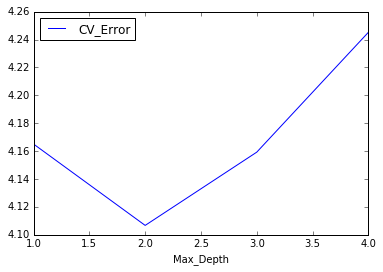

In [20]:
depth = range(1,5)
scores = []
for i in depth:
    GBR_Tree = GradientBoostingRegressor(learning_rate = 0.01, # This is lambda, a tuning parameter, usually between 0.01 and 0.1
                                            n_estimators = 10000, #This is B, a tuning parameter, using large B can cause overfitting
                                            max_depth = i, #This is d, another tuning parameter, usually max_depth < 5
                                            min_samples_leaf = 5  )  
    cv_error = cross_val_score(GBR_Tree,X,y,cv=10,scoring='mean_squared_error')
    scores.append(np.mean(np.sqrt(-cv_error)))

depth_choice_df = pd.DataFrame({'CV_Error': scores,'Max_Depth': depth})
print depth_choice_df
depth_choice_df.plot(x ='Max_Depth', y = 'CV_Error')

# It seems like Max_Depth = 2 gives us the lowest CV-Error

   CV_Error  Number Of Trees
0  5.626437              100
1  3.911931             1000
2  3.959272             5000
3  4.098878            10000
4  4.202749            20000


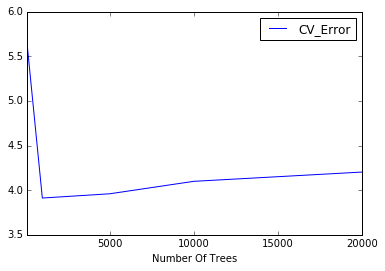

In [21]:
NumberOfTrees = [100,1000,5000,10000,20000]
scores = []
for i in NumberOfTrees:
    GBR_Tree = GradientBoostingRegressor(learning_rate = 0.01, # This is lambda, a tuning parameter, usually between 0.01 and 0.1
                                            n_estimators = i, #This is B, a tuning parameter, using large B can cause overfitting
                                            max_depth = 2, #This is d, another tuning parameter, usually max_depth < 5
                                            min_samples_leaf = 5  )  
    cv_error = cross_val_score(GBR_Tree,X,y,cv=10,scoring='mean_squared_error')
    scores.append(np.mean(np.sqrt(-cv_error)))

num_trees_df = pd.DataFrame({'CV_Error': scores, 'Number Of Trees': NumberOfTrees})
print num_trees_df
num_trees_df.plot(x ='Number Of Trees', y = 'CV_Error')

# It seems like at Tree_Size = 1000 we have reduced our error to 3.9 which is great! 
# You can localize your search. Even further. For example try size of tree from 500 to 5000 with increments of 100
# Remember Learning Rate and Number of trees should be tuned with one another. Lower learning rates require more trees

# Boosting Algorithm - Classification

Please refer to the following link for its documentation: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [22]:
#Reset y to be categorical
y = BostonData['medvCategory']

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation
GBC_Tree = GradientBoostingClassifier(learning_rate = 0.01,
                                      n_estimators = 1000,
                                      max_depth = 2,
                                      min_samples_leaf = 5)

# Unfortunately we cannot use cross_val_score in this case. cross_val_score returns log of loss which is not a 
# measure of interest here

kf = cross_validation.KFold(len(BostonData), n_folds=10, shuffle=True) #10 fold CV
scores = []
for train_index, test_index in kf:   
        GBC_Tree.fit(X.iloc[train_index], y.iloc[train_index])
        y_hat_test = GBC_Tree.predict(X.iloc[test_index]) 
        scores.append(float(sum(y_hat_test == y.iloc[test_index]))/len(y_hat_test))

Score_GBC_CV = np.mean(scores)    

print(Score_GBC_CV) #Based on this setting, 73.7% of time we predict correct outcomes
# in order to improve this result we need to tune our algorithm

0.769019607843


# Tune your algorithm to get better predictibility

In [ ]:
depth = range(1,5)
scores_GBC_cv = []
for i in depth:
    GBC_Tree = GradientBoostingClassifier(learning_rate=0.01, n_estimators=10000, max_depth=i, min_samples_leaf = 5)
    kf = cross_validation.KFold(len(BostonData), n_folds=10, shuffle=True) #10 fold CV
    scores = []
    for train_index, test_index in kf:   
        GBC_Tree.fit(X.iloc[train_index], y.iloc[train_index])
        y_hat_test = GBC_Tree.predict(X.iloc[test_index]) 
        scores.append(float(sum(y_hat_test == y.iloc[test_index]))/len(y_hat_test))
    scores_GBC_cv.append(np.mean(scores))

depth_choice_df = pd.DataFrame({'depth':depth,'gbc_cv_scores':scores_GBC_cv})
print depth_choice_df
depth_choice_df.plot(x='depth',y='gbc_cv_scores')

Looks like depth of 3 is ideal

   gbc_cv_scores  num_trees
0       0.725333        100
1       0.735020       1000
2       0.741294       5000
3       0.741333      10000
4       0.735137      20000


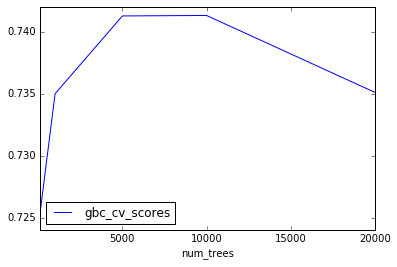

In [27]:
num_trees = [100,1000,5000,10000,20000]
scores_GBC_cv = []
for i in num_trees:
    GBC_Tree = GradientBoostingClassifier(learning_rate=0.01, n_estimators=i, max_depth=3, min_samples_leaf = 5)
    kf = cross_validation.KFold(len(BostonData), n_folds=10, shuffle=True) #10 fold CV
    scores = []
    for train_index, test_index in kf:   
        GBC_Tree.fit(X.iloc[train_index], y.iloc[train_index])
        y_hat_test = GBC_Tree.predict(X.iloc[test_index]) 
        scores.append(float(sum(y_hat_test == y.iloc[test_index]))/len(y_hat_test))
    scores_GBC_cv.append(np.mean(scores))

num_trees_df = pd.DataFrame({'num_trees':num_trees,'gbc_cv_scores':scores_GBC_cv})
print num_trees_df
num_trees_df.plot(x='num_trees',y='gbc_cv_scores')

The best number of estimators/trees is 5000

In [28]:
GBC_Tree = GradientBoostingClassifier(learning_rate = 0.01,
                                      n_estimators = 5000,
                                      max_depth = 3,
                                      min_samples_leaf = 5)

kf = cross_validation.KFold(len(BostonData), n_folds=10, shuffle=True) #10 fold CV
scores = []
for train_index, test_index in kf:   
        GBC_Tree.fit(X.iloc[train_index], y.iloc[train_index])
        y_hat_test = GBC_Tree.predict(X.iloc[test_index]) 
        scores.append(float(sum(y_hat_test == y.iloc[test_index]))/len(y_hat_test))
Score_GBC_CV = np.mean(scores)    
print(Score_GBC_CV)

0.738823529412
